In [1]:
#We import the necessary libraries.
%matplotlib inline

In [2]:
import os

In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize
from importlib import reload

In [4]:
import corner

In [5]:
import radvel

In [6]:
from matplotlib import rcParams

#We change the formatting of the plots.
    #rcParams["axes.formatter.useoffset"] = False => Disabling the automatic offset for tick labels, since its False
#full numbers will be displayed.
    #rcParams['axes.formatter.limits'] = -15,15 => If the tick labels are outside of range (-15, 15) Matplotlib will
#use Scientific Notation.
    #rcParams['mathtext.fontset'] = 'stix' => "STIX" font will be used for mathematical symbols, this font is used 
#in publications.
    #rcParams['font.family'] = 'STIXGeneral' => "STIXGeneral" is a part of the font family, ensures the text and
#labels also use this font.
    #rcParams['xtick.direction']='in' => This changes the direction of the x-axis tick marks to point inward,
#towards the plot area.
    #rcParams['ytick.direction']='in' => This changes the direction of the y-axis tick marks to point inward,
#towards the plot area.
rcParams["axes.formatter.useoffset"] = False
rcParams['axes.formatter.limits'] = -15,15
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['xtick.direction']='in'
rcParams['ytick.direction']='in'

#import sys
#sys.path.pop(0)

#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [7]:
#We read the datafile of TOI-2431.
df_raw = pd.read_csv('../../data/rvdata/toi2431.csv')

#We also add another column called "tel" to these DataFrames.
#This describes the instrument that was used to obtain these data.
df_raw['tel'] = ['MERCATOR' for i in range(len(df_raw))]

#We only take "bjd", "rv", "e_rv" and "tel" columns from the df_all as follows. (We basically remove other columns)
df = df_raw[['bjd','rv','rv_err','tel']]

#Then we define those columns as "time", "mnvel", "errvel" and "tel" as follows.
df.columns = ['time','mnvel','errvel','tel']

df

time         mnvel    errvel       tel
0   2.460592e+06  12621.868601  5.579195  MERCATOR
1   2.460592e+06  12630.707306  5.826783  MERCATOR
2   2.460592e+06  12619.683856  5.080273  MERCATOR
3   2.460594e+06  12558.849808  5.357000  MERCATOR
4   2.460594e+06  12547.456778  4.745870  MERCATOR
5   2.460594e+06  12594.033997  4.939086  MERCATOR
6   2.460594e+06  12541.034216  4.434962  MERCATOR
7   2.460594e+06  12542.182484  4.326742  MERCATOR
8   2.460594e+06  12508.929904  4.669010  MERCATOR
9   2.460595e+06  12544.342869  6.305908  MERCATOR
10  2.460595e+06  12556.059556  4.999976  MERCATOR
11  2.460596e+06  12538.506126  4.976371  MERCATOR
12  2.460601e+06  12480.046573  4.853639  MERCATOR
13  2.460601e+06  12476.575201  5.790739  MERCATOR

In [8]:
#Now we import the GaiaRV source codes.
import sys
sys.path.insert(0, '../../gaiafit/')
try:
    sys.path.remove('\\wsl.localhost\\Ubuntu\\home\\kayahan')
except Exception as e:
    print(e)

#We import utils.py, gaiafit.py, gaiasource.py as follows.
import utils
import gaiafit
import gaiasource
reload(gaiafit)

gaiafit, gaiasource, utils

list.remove(x): x not in list


(<module 'gaiafit' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiafit.py'>,
 <module 'gaiasource' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/gaiasource.py'>,
 <module 'utils' from '/home/kayahan/ExoSoft/notebooks/rv-tests/../../gaiafit/utils.py'>)

In [9]:
#We get the Prior File for the target we are analyzing as follows.
#Please open one of the .txt files to see how to setup the Prior Files.
f = '../../data/priors/TOI2431_Priors.txt'
reload(gaiafit)

#We get the time, radial velocity and error of radial velocities for the first instrument/dataset.
t = df_raw.bjd.values
rv = df_raw.rv.values
e_rv = df_raw.rv_err.values

#We then use "LPFunctionRVOnly" from the "gaiafit.py" code to do the fitting.
    #LPFunction => Likelihood Function
    #RVOnly => Tells you that it is only doing RV analysis, not Gaia Astrometric Analysis.

#Note that LPFunctionRVOnly plots the Priors.
L = gaiafit.LPFunctionRVOnly(t,rv,e_rv,file_priors=f)

#We do a Gaia Fit for RV Only as follows. (Needs the Likelihood Function to work)
TF = gaiafit.GaiaFitRVOnly(L)

Reading in priorfile from ../../data/priors/TOI2431_Priors.txt
   prior          arg1          arg2        label  description priortype  \
0     NP  6.400000e-01  8.469820e-02        mstar        mstar     model   
1     UP  3.000000e-03  3.000000e-01           mp           mp     model   
2     NP  2.241958e-01  5.480000e-08         P_p1         P_p1     model   
3     NP  2.460259e+06  1.573097e-04        tp_p1        tp_p1     model   
4     UP  0.000000e+00  1.000000e-01       ecc_p1       ecc_p1     model   
5     UP  0.000000e+00  3.600000e+02     omega_p1     omega_p1     model   
6     UP  4.000000e+01  1.500000e+02         K_p1         K_p1     model   
7     UP  1.230000e+04  1.280000e+04        gamma        gamma     model   
8     UP  1.000000e-01  1.000000e+02     sigma_rv     sigma_rv     model   
9     FP  0.000000e+00  0.000000e+00     gammadot     gammadot     model   
10    FP  0.000000e+00  0.000000e+00  gammadotdot  gammadotdot     model   

    fixed  
0   False  


In [10]:
#We do the Minimization using PyDE as follows.
#Note that the Minimization includes the MCMC i.e. the Parameter Space exploration.
TF.minimize_PyDE(de_iter=200,mc_iter=5000,)

Running PyDE Optimizer
Optimized using PyDE
Final parameters:
     labels       centers         lower         upper            pv   center_dist
0     mstar  6.400000e-01  2.165090e-01  1.063491e+00  6.339584e-01  6.041622e-03
1        mp  1.515000e-01  3.000000e-03  3.000000e-01  2.068062e-01 -5.530619e-02
2      P_p1  2.241958e-01  2.241955e-01  2.241961e-01  2.241958e-01  8.030454e-09
3     tp_p1  2.460259e+06  2.460259e+06  2.460259e+06  2.460259e+06  1.904508e-05
4    ecc_p1  5.000000e-02  0.000000e+00  1.000000e-01  5.636389e-02 -6.363891e-03
5  omega_p1  1.800000e+02  0.000000e+00  3.600000e+02  3.372649e+02 -1.572649e+02
6      K_p1  9.500000e+01  4.000000e+01  1.500000e+02  6.721092e+01  2.778908e+01
7     gamma  1.255000e+04  1.230000e+04  1.280000e+04  1.255779e+04 -7.788642e+00
8  sigma_rv  5.005000e+01  1.000000e-01  1.000000e+02  2.115355e+01  2.889645e+01
LogPost value: -55.599123757792775
LnL value: -62.878474984536446
Log priors 7.279351226743671
Running MCMC
MCMC itera

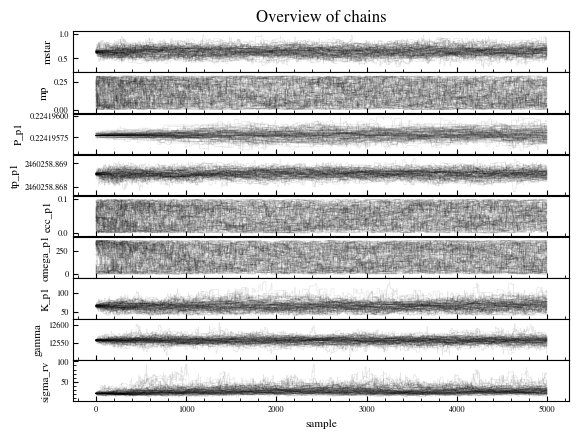

In [11]:
#We import mcmc_help.
import mcmc_help

#We use the plot_chains function to plot the chains as follows.
mcmc_help.plot_chains(TF.sampler.chain,labels=TF.lpf.ps_vary.labels)

plt.show();

In [12]:
#We define the burn in index to be 1000.
#This means that the first 1000 samples per chain will be ignored.
burnin_index = 1000

#We extract the chains after the burn in phase. (?)
    #First part: We take all the chains.
    #Second part: We ignore the first 1000 samples per chain. (hence "burnin_index")
    #Third part: We take all the parameters.
chains_after_burnin = TF.sampler.chain[:,burnin_index:,:]

#We then flatten the chains as follows.
flatchain = chains_after_burnin.reshape((-1,len(TF.lpf.ps_vary.priors)))

#To store the posteriors we have obtained from the chains, we define a Pandas DataFrame as follows.
df_post = pd.DataFrame(flatchain,columns=TF.lpf.ps_vary.labels)

df_post

mstar        mp      P_p1         tp_p1    ecc_p1    omega_p1  \
0       0.616014  0.147911  0.224196  2.460259e+06  0.004638  299.746364   
1       0.616014  0.147911  0.224196  2.460259e+06  0.004638  299.746364   
2       0.616014  0.147911  0.224196  2.460259e+06  0.004638  299.746364   
3       0.616014  0.147911  0.224196  2.460259e+06  0.004638  299.746364   
4       0.616014  0.147911  0.224196  2.460259e+06  0.004638  299.746364   
...          ...       ...       ...           ...       ...         ...   
399995  0.557118  0.123172  0.224196  2.460259e+06  0.049527  356.955443   
399996  0.557118  0.123172  0.224196  2.460259e+06  0.049527  356.955443   
399997  0.557118  0.123172  0.224196  2.460259e+06  0.049527  356.955443   
399998  0.557118  0.123172  0.224196  2.460259e+06  0.049527  356.955443   
399999  0.557118  0.123172  0.224196  2.460259e+06  0.049527  356.955443   

             K_p1         gamma   sigma_rv  
0       63.416317  12562.336702  23.181901  
1       63.416317  12562.336702  23.181901  
2       63.416317  12562.336702  23.181901  
3       63.416317  12562.336702  23.181901  
4       63.416317  12562.336702  23.181901  
...           ...           ...        ...  
399995  54.374606  12564.218186  25.111056  
399996  54.374606  12564.218186  25.111056  
399997  54.374606  12564.218186  25.111056  
399998  54.374606  12564.218186  25.111056  
399999  54.374606  12564.218186  25.111056  

[400000 rows x 9 columns]

In [13]:
#We calculate the Planet Mass using the posteriors K, Mstar, P and Eccentricity.
df_post['mp'] = utils.msini_from_rvs(df_post["K_p1"].values,df_post["mstar"].values,
                                     df_post["P_p1"].values,e=0,
                                     i=90)

df_post["mp"]

0         0.137231
1         0.137231
2         0.137231
3         0.137231
4         0.137231
            ...   
399995    0.110040
399996    0.110040
399997    0.110040
399998    0.110040
399999    0.110040
Name: mp, Length: 400000, dtype: float64

In [14]:
#We print out the median values as follows.
df_medvals = TF.get_mean_values_mcmc_posteriors(df_post.values)
df_medvals[['Labels','values']]

Labels                                     values
0     mstar                  $0.642_{-0.083}^{+0.080}$
0        mp                  $0.144_{-0.026}^{+0.028}$
0      P_p1  $0.224195781_{-0.00000005}^{+0.00000005}$
0     tp_p1      $2460258.86857_{-0.00016}^{+0.00015}$
0    ecc_p1                  $0.049_{-0.033}^{+0.033}$
0  omega_p1                  $180.0_{-130.0}^{+130.0}$
0      K_p1                     $65.0_{-10.0}^{+11.0}$
0     gamma                    $12557.4_{-7.8}^{+7.6}$
0  sigma_rv                       $26.6_{-5.3}^{+8.4}$

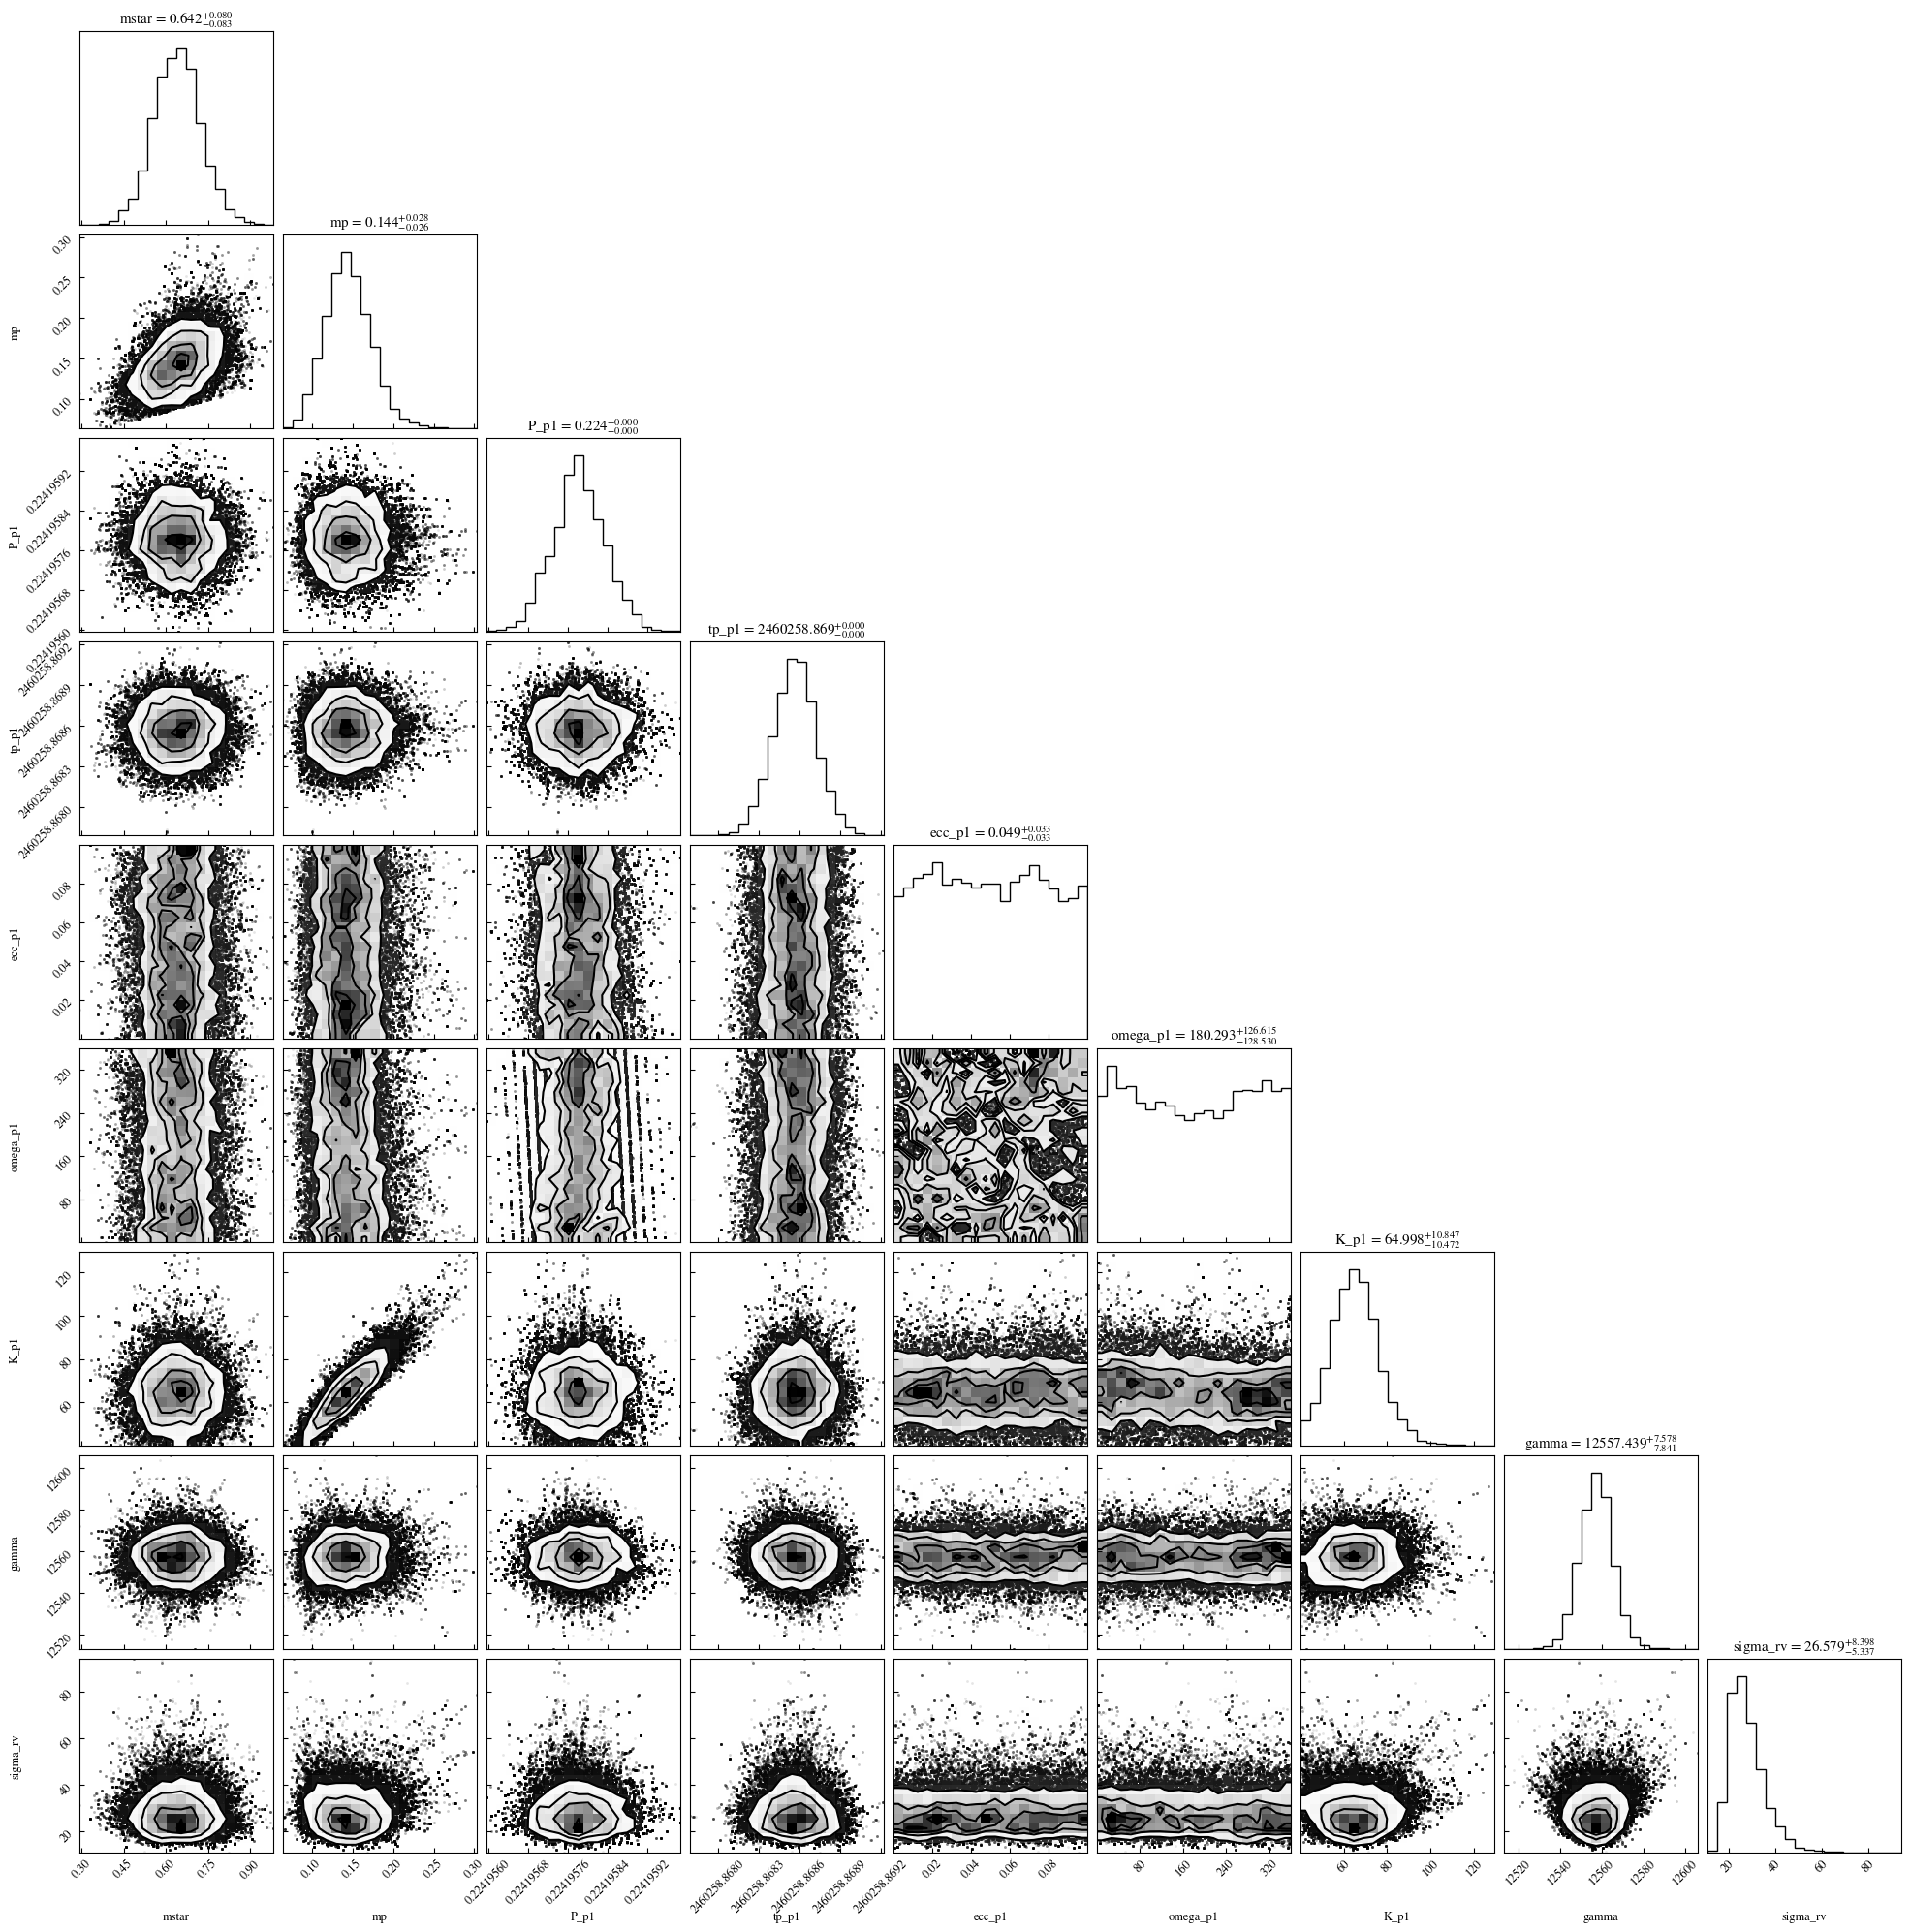

In [15]:
#We then plot the Corner Plot.
import corner
corner.corner(df_post.iloc[:,:].values,
       show_titles=True,labels=list(df_post.iloc[:,:].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

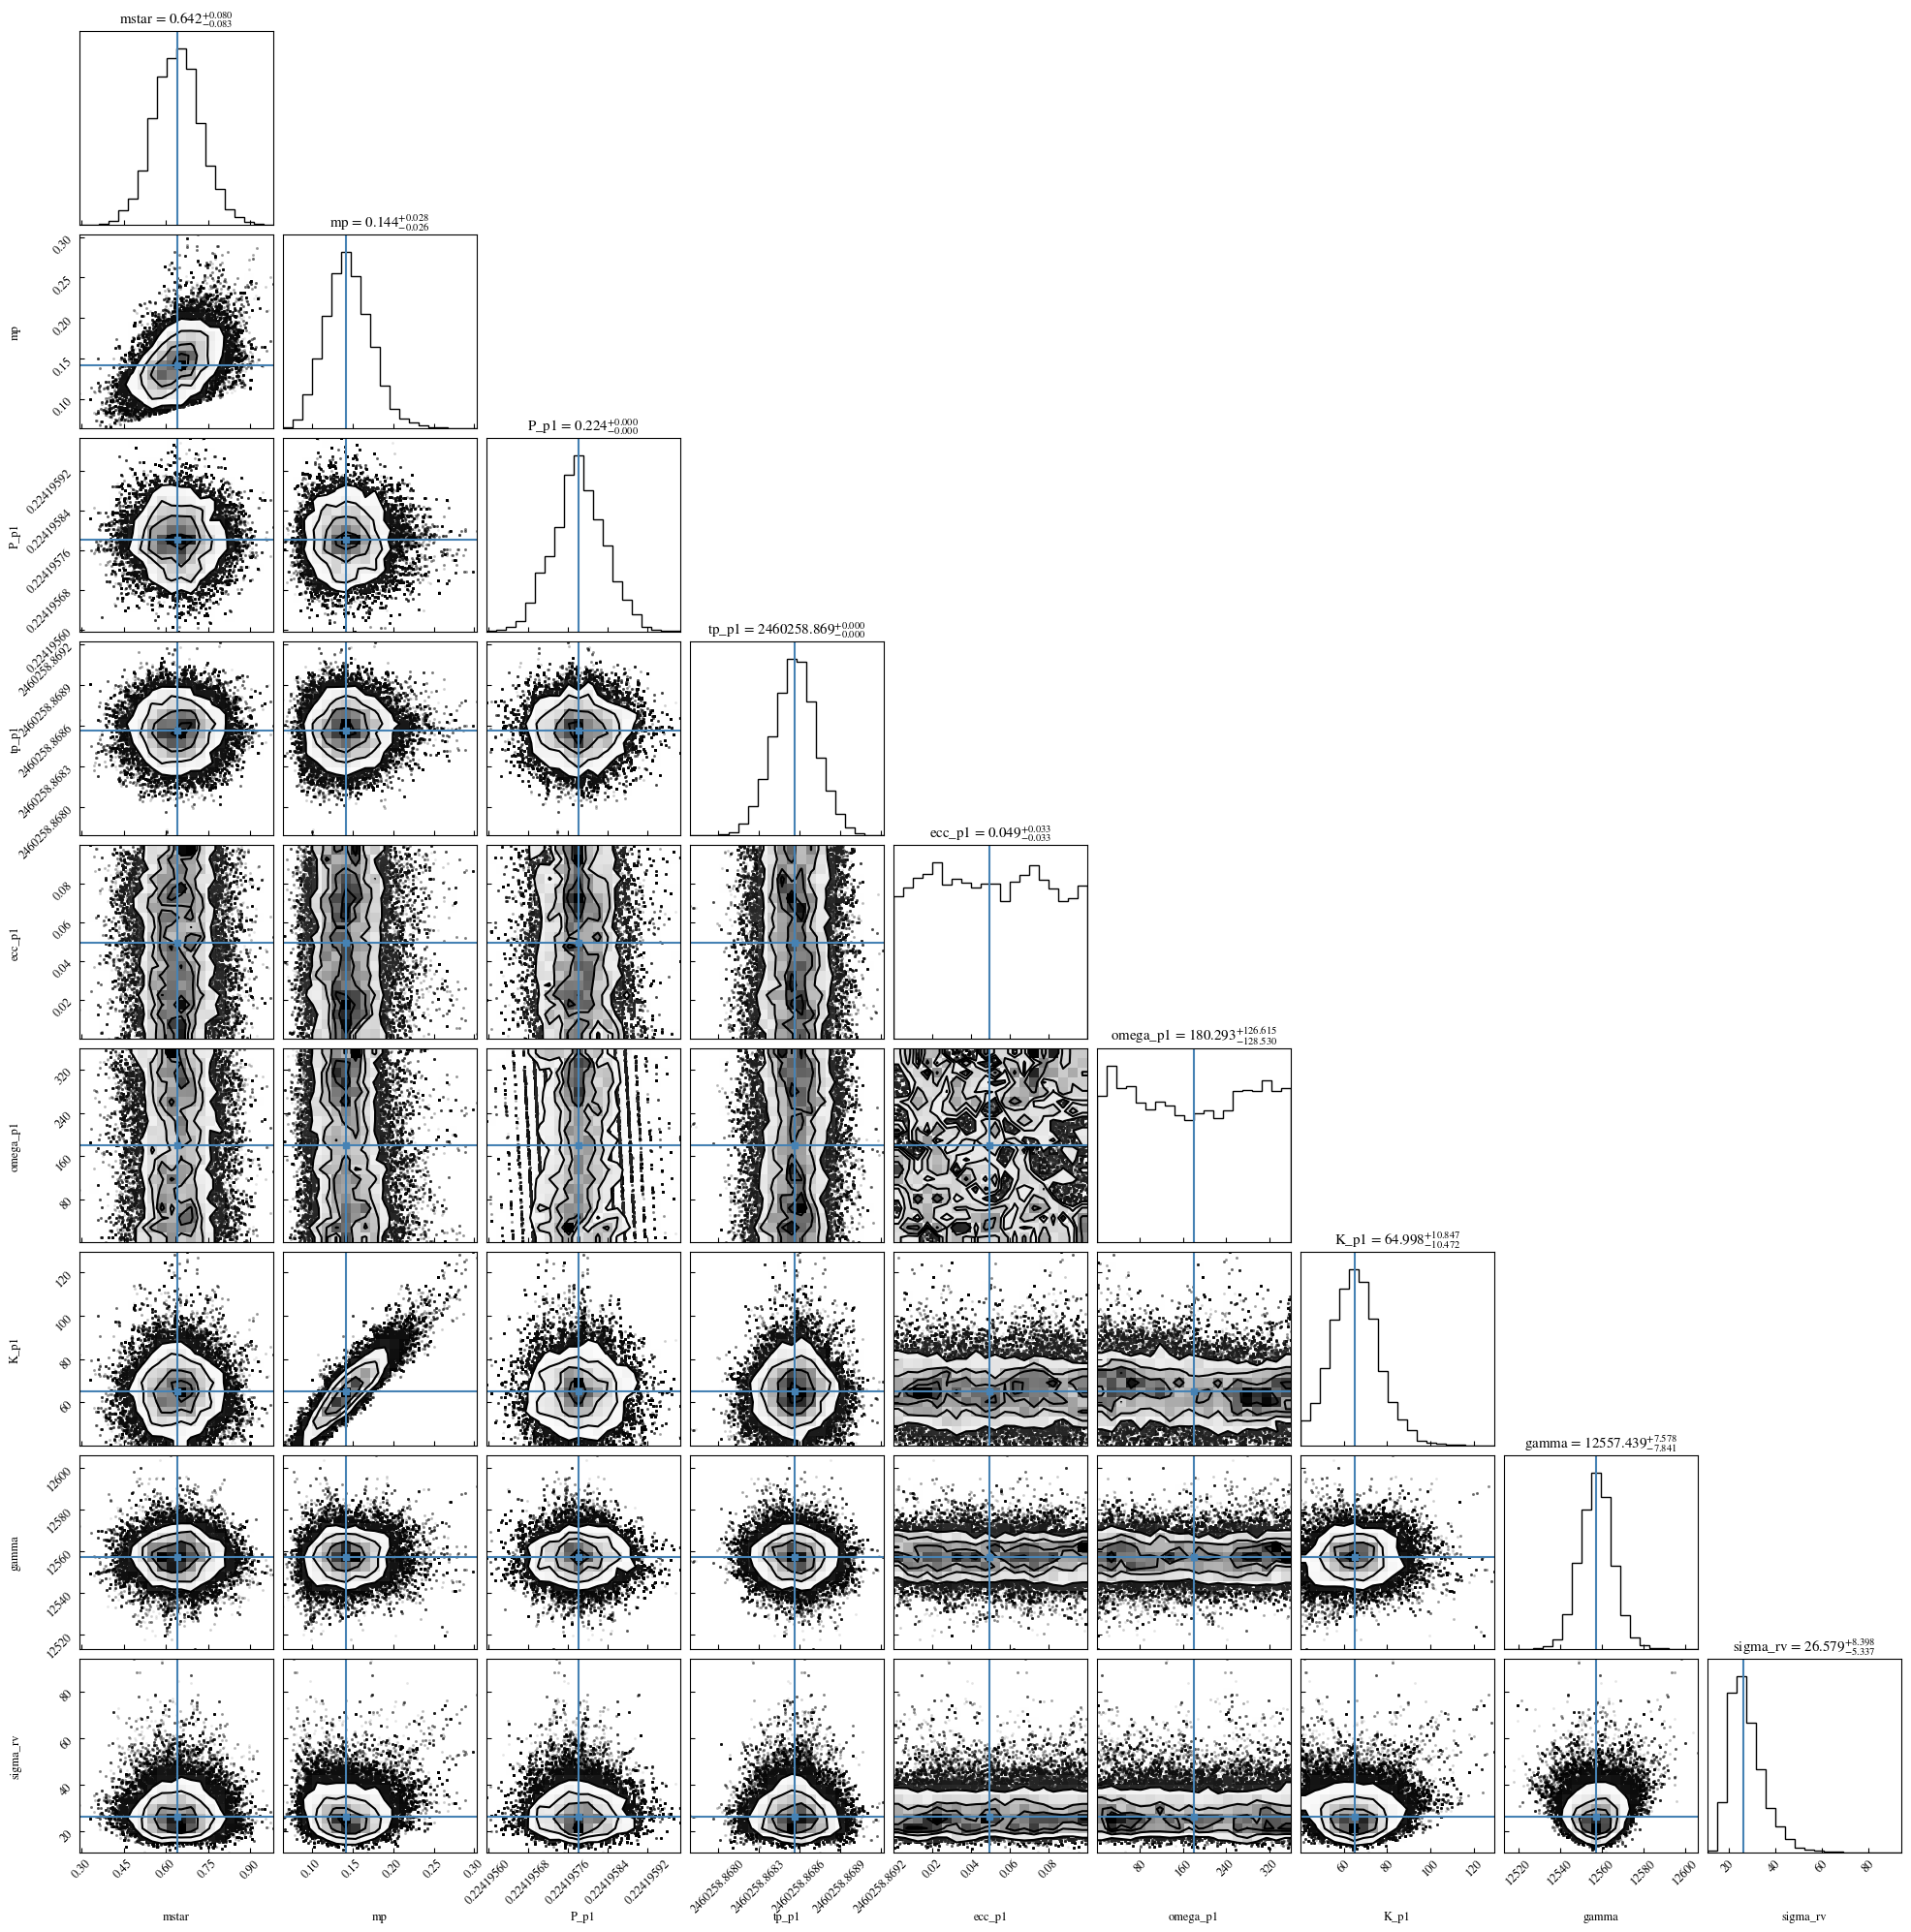

In [16]:
#We again plot the Corner plot but this time with the Truths included to compare them with the values we have obtained from MCMC.
import corner
pv_50 = np.percentile(flatchain,[50],axis=0)[0]
corner.corner(df_post.iloc[:, :].values,truths=pv_50,
       show_titles=True,labels=list(df_post.iloc[:, :].columns),title_fmt='.3f',xlabcord=(0.5, -0.2));

plt.show();

In [17]:
#We get the Mass from the MCMC chains to convert it to Earth Mass values.
obj = [df_medvals[df_medvals.Labels=='mp']['values'].values[0]]

#We then extract the numbers and remove the $ and {} characters
cleaned_str = obj[0].replace('$', '').replace('{', '').replace('}', '').replace('_', '').replace('^', '')

#Now we have to split the string by the symbols into central, lower, and upper values
central_value, lower_error, upper_error = cleaned_str.split('-')[0], cleaned_str.split('-')[1].split('+')[0], cleaned_str.split('+')[1]

#Now we convert all of them to floats and multiply them Earth Mass factor. (1 M_Jupiter = 317.83 M_Earth)
factor = 317.83
central_value = float(central_value) * factor
lower_error = float(lower_error) * factor
upper_error = float(upper_error) * factor

#We then format it back to the original string from the output.
mass_converted = f"${central_value:.3f}_{{-{lower_error:.3f}}}^{{+{upper_error:.3f}}}$"
print(mass_converted)

$45.768_{-8.264}^{+8.899}$


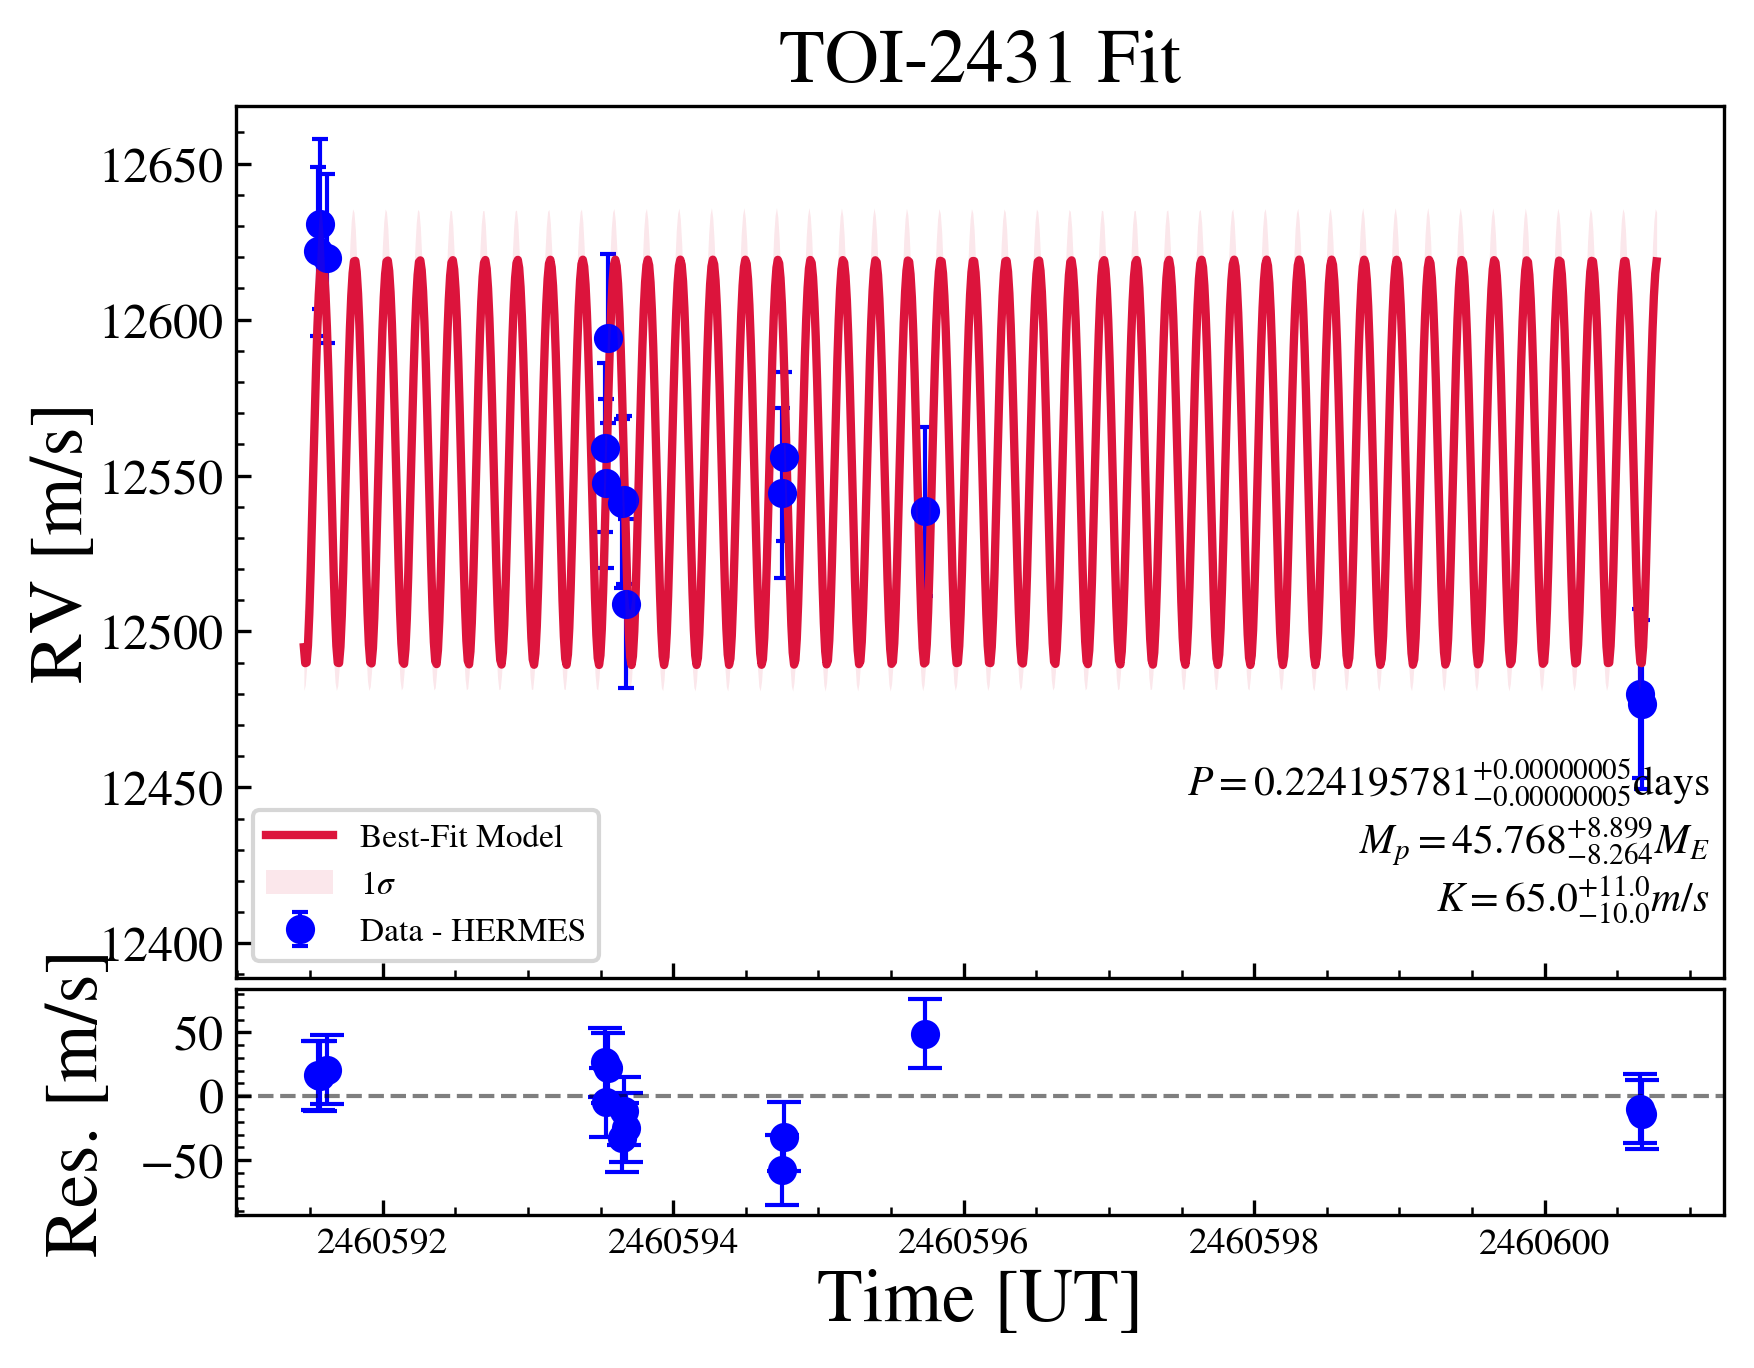

In [21]:
#We import astropy.time to convert Julian Dates into Datetimes i.e. the DD-MM-YYYY Format.
import astropy.time

#We define a function that turns Julian Dates into Datetime format.
def jd2datetime(times):
    return times
    #return np.array([astropy.time.Time(time,format="jd",scale="utc").datetime for time in times])

#We define the Title, Number of Models and the Shade color.
TITLE = 'TOI-2431 Fit'
NUMMODELS = 5000
shadecolor="black"

###################
#We define the times using the JD Times from the first and second dataset.
#Note that we define 500 time points.
times1 = np.linspace(TF.lpf.data['x'][0]-0.05,TF.lpf.data['x'][-1]+0.05,500)

#We define the 50th Percentile i.e. the Median by using the Flatchain we defined.
#The "[0]" is to get the percentiles out of the array and turn it into a list.
pv_50 = np.percentile(flatchain,[50],axis=0)[0]

#We define times for the model/fit this time, using the minimum and maximum times.
#Note that we define 300 time points for the fit.
t1_mod = np.linspace(times1.min()-0.05,times1.max()+0.05,1000)

#Our goal is to get the Residuals i.e. Data - Model.
#For that first we compute the Radial Velocities for both instruments using 50th percentiles i.e. the Model.
rv_501 = TF.lpf.compute_total_model(pv_50,t1_mod)

#Then we get the Radial Velocities for both instruments using the datafiles we have i.e. Data.
rv_50_obs1 = TF.lpf.compute_total_model(pv_50,TF.lpf.data['x'])

#We calculate the residuals.
res1 = TF.lpf.data['y'] - rv_50_obs1

#We define the Figure and the Axes.
#Note that we have two rows with one of them showing the RV and the other one showing the Residuals.
fig, (ax,bx) = plt.subplots(dpi=300,nrows=2,gridspec_kw={'height_ratios': [5,1.3]},sharex=True)

#################
# Plot data
#################
#We first plot the Best-Fit Model.
#For that we first define a label.
label = r'Best-Fit Model'

#Then we also add the values of Period and Eccentricity into our label.
#Note that we are using "df_medvals" we found after MCMC.
#Note that we can also add Planet Mass and Inclination by removing "#" from the lines below.
lab = '$P=${}'.format(df_medvals[df_medvals.Labels=='P_p1']['values'].values[0])+'days\n'
lab += r'$M_p=${}$M_E$'.format(mass_converted)+'\n'
#lab += r'$e=${}'.format(df_medvals[df_medvals.Labels=='ecc_p1']['values'].values[0])+'\n'
lab += r'$K=${}$m/s$'.format(df_medvals[df_medvals.Labels=='K_p1']['values'].values[0])+'\n'

#We define the marker color to be black for errorbars.
markercolor="blue"

uncertainty_sigma = df_medvals["medvals"][df_medvals["Labels"] == "sigma_rv"].values[0]
inflated_rv_err = np.sqrt(pow(TF.lpf.data['error'],2)+(pow(uncertainty_sigma,2)))

#We define the errorbars & datapoints.
#Note that we put times into the jd2datetime function so that the dates turn from JD to Datetime.
#ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],TF.lpf.data['error'],
            #marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color=markercolor,markersize=6,label='Data - HERMES')
ax.errorbar(jd2datetime(TF.lpf.data['x']),TF.lpf.data['y'],inflated_rv_err,
             marker='o',elinewidth=1,capsize=2,lw=0,mew=1,color="blue",markersize=6,label='Data - HERMES',
             zorder = -10)

#We finally also plot our model as follows.
ax.plot(jd2datetime(t1_mod),rv_501,color="crimson",label=label,lw=2.,zorder=-10)

#Now we work on the second Row for the Resiudal graph.
#We also need to plot the residuals with the error bars included.

#For that we define the errorbars & datapoints for the first dataset from first instrument.
# bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,TF.lpf.data['error'],
#             marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color=markercolor,markersize=6)
bx.errorbar(jd2datetime(TF.lpf.data['x']),res1,inflated_rv_err,
             marker='o',elinewidth=1,capsize=4,lw=0,mew=1,color="blue",markersize=6, zorder=-10)

#We add the values of our Parameters to the Bottom-Right of our first Graph i.e. RV Graph.
ax.text(0.99,0.01,lab,va='bottom',ha='right',fontsize=10,transform=ax.transAxes)

#We define a list to sample from our model, which we will use for Sigma Errors of our Fit.
mmodel1 = []
for i in range(NUMMODELS):
    #if i%100 == 0: print("Sampling, i=",i)
    idx = np.random.randint(0, flatchain.shape[0])
    m1 = TF.lpf.compute_total_model(flatchain[idx],times=t1_mod)
    mmodel1.append(m1)
mmodel1 = np.array(mmodel1)

#We then show the 1-Sigma Error of our fit as follows.
#There are also options for 2-Sigma and 3-Sigma Errors, commented below.
ax.fill_between(jd2datetime(t1_mod),np.quantile(mmodel1,0.16,axis=0),np.quantile(mmodel1,0.84,axis=0),
                alpha=0.1,color='crimson',lw=0,label='1$\sigma$',zorder=-1)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Time [UT]',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-50, ylim[-1]+0)

#plt.savefig("toi_2431_result.png", dpi = 500)
plt.show();

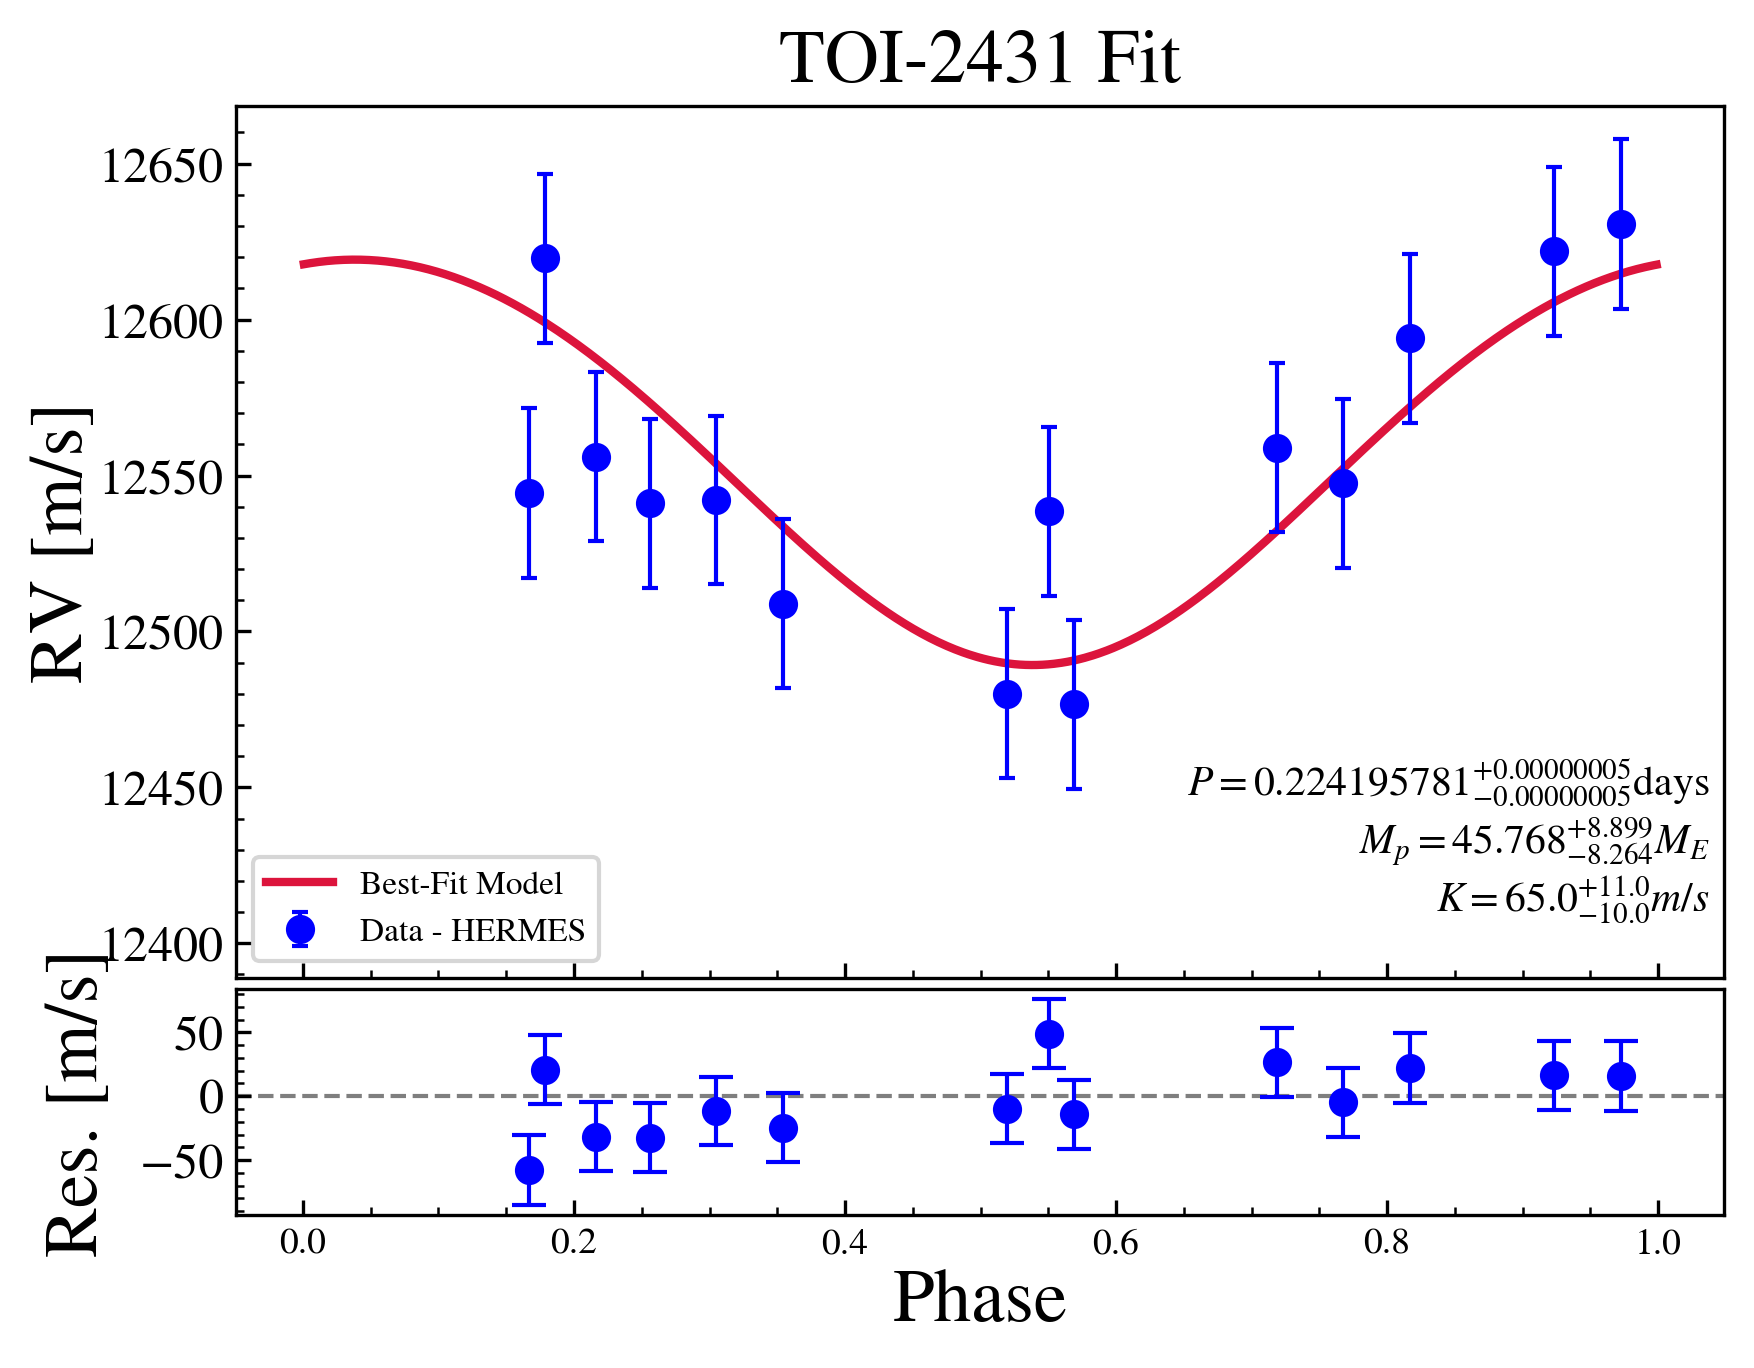

In [22]:
#We get the P and T0 values from the MCMC results.
P = df_medvals["medvals"][df_medvals["Labels"] == "P_p1"].values[0]
T_0 = df_medvals["medvals"][df_medvals["Labels"] == "tp_p1"].values[0]

#We then define a function to convert observation times to the Orbital Phase.
def time_to_phase(times, P, T_0):
    """Takes the Observation Times, Period and the T0. Returns the orbital 
    phases for given Observation Times.
    
    Input:
    ----------------------------------------------------------------------------
    times: Array of observation times (Julian Dates)
    P: Orbital period in days
    T_0: Reference time (epoch or time of periastron) in Julian Date
    
    Output:
    ----------------------------------------------------------------------------
    ((times - T_0) % P) / P: Orbital Phases
    
    """
    
    #Normalize time to phase in the range [0, 1]
    return ((times - T_0) % P) / P

#We convert the observation times from our data to the orbital phases.
phase1 = time_to_phase(TF.lpf.data['x'], P, T_0)

#We also convert the times for the model/fit to the orbital phases.
phase_model = time_to_phase(t1_mod, P, T_0)

#Now we define a figure again for our Phase Curve & Residuals.
fig, (ax, bx) = plt.subplots(dpi=300, nrows=2, gridspec_kw={'height_ratios': [5, 1.3]}, sharex=True)

#################
# Plot data
#################

#We first sort our data according to the Phase values we have.
sorted_indices = np.argsort(phase_model)
phase_model_sorted = phase_model[sorted_indices]
rv_501_sorted = rv_501[sorted_indices]

#Then we plot the fit as follows.
label = r'Best-Fit Model'
ax.plot(phase_model_sorted, rv_501_sorted, color="crimson", label=label, lw=2., zorder=-10)

#We then plot our data around the fit as follows.
ax.errorbar(phase1, TF.lpf.data['y'], inflated_rv_err,
            marker='o', elinewidth=1, capsize=2, lw=0, mew=1, color=markercolor, markersize=6, label='Data - HERMES')

#We plot the residuals on the second row as follows.
res1 = TF.lpf.data['y'] - rv_50_obs1
bx.errorbar(phase1, res1, inflated_rv_err,
            marker='o', elinewidth=1, capsize=4, lw=0, mew=1, color=markercolor, markersize=6)

#We add the label for the fit parameters
ax.text(0.99, 0.01, lab, va='bottom', ha='right', fontsize=10, transform=ax.transAxes)

# For plotting the sigma errors (1-sigma range) - Does not work.
# mmodel1 = []
# for i in range(NUMMODELS):
#     idx = np.random.randint(0, flatchain.shape[0])
#     m1 = TF.lpf.compute_total_model(flatchain[idx], times=t1_mod)
#     mmodel1.append(m1)
# mmodel1 = np.array(mmodel1)

# # Plot 1-sigma error range
# ax.fill_between(phase_model, np.quantile(mmodel1, 0.16, axis=0), np.quantile(mmodel1, 0.84, axis=0),
#                 alpha=0.1, color='crimson', lw=0, label='1$\sigma$', zorder=-1)

#We add the legend and the labels.
ax.legend(loc='lower left', fontsize=8)
ax.set_ylabel('RV [m/s]', labelpad=0, fontsize=18)
bx.set_xlabel('Phase', labelpad=2, fontsize=18)
bx.set_ylabel('Res. [m/s]', labelpad=6, fontsize=18)

#We show define the legend for the first row i.e. the RV Graph.
ax.legend(loc='lower left',fontsize=8)

#We define the x-axis and y-axis labels for the second row i.e. the Residuals Graph.
bx.set_xlabel('Phase',labelpad=2,fontsize=18)
bx.set_ylabel('Res. [m/s]',labelpad=6,fontsize=18)

#We also define the x-axis of the first row i.e. the RV Graph.
ax.set_ylabel('RV [m/s]',labelpad=0,fontsize=18)

#We then define the x limit by using ax.get_xlim()
xlim = ax.get_xlim()

#Using the x limits we define the new xlim to be the first and second element of the xlim array.
ax.set_xlim(xlim[0],xlim[1])

#We define extra times to plot the zero-line for Residuals.
_x = np.linspace(xlim[0],xlim[-1],100)

#We use the extra times we defined to plot the zero-line for residuals.
bx.plot(_x,0*np.ones(100),color='black',ls='--',lw=1,alpha=0.5,zorder=-10)

#We then set a 0.02 horizontal space between the rows. (Tighter than the default setup.)
fig.subplots_adjust(hspace=0.02)

for xx in [ax,bx]:
    utils.ax_apply_settings(xx)
    xx.grid(lw=0)

bx.tick_params(axis='x',labelsize=9)
ax.set_title(TITLE,fontsize=18)#,y=1.05)

ylim = ax.get_ylim()
ax.set_ylim(ylim[0]-50, ylim[-1]+0)

#plt.savefig("toi_2431_result_phase.png", dpi = 500)
plt.show();

In [20]:
#Adding audio to know the fit has finished.
from IPython.display import Audio

beep = np.sin(2*np.pi*800*np.arange(3000*2)/100000)
Audio(beep, rate=100000, autoplay=True)